#  word2vec, doc2vec и fasttext 


1. word2vec – векторное представление слова
2. как сделать вектор документа?
    * усреднить все вектора слов
    * усреднить все вектора слов с $tf-idf$ весами
    * doc2vec
3. fasttext – векторное представление $n$-грам


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.metrics import *
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
random.seed(1228)

%matplotlib inline

Загружаем лемматизированные статьи без стоп-слов и создаем массив текстов

In [2]:
from pymystem3 import Mystem
import re


m = Mystem()


regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""



def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


In [3]:
df_neg = pd.read_csv("../data/negative.csv", sep=';', header = None, usecols = [3])
df_pos = pd.read_csv("../data/positive.csv", sep=';', header = None, usecols = [3])
df_neg['sent'] = 'neg'
df_pos['sent'] = 'pos'
df = pd.concat([df_neg, df_pos])
df.columns = ['text', 'sent']
df.text = df.text.apply(words_only)
df.text = df.text.apply(lemmatize)

In [4]:
df.head()

,text,sent
0,на работа быть полный пиддеса :| и так каждый ...,neg
1,коллега сидеть рубиться в Urban terror а я из ...,neg
2,elina_ post как говорить обещаной три год ждат...,neg
3,желать хороший пол тот и удачный посадка я быт...,neg
4,обновлять за какой то леший surf теперь не раб...,neg


In [5]:
texts = [df.text.iloc[i].split() for i in range(len(df))]

# Модель word2vec

## Общая идея

По слову $w$ предсказываем слово $w'$

![img](img/w2v_1.png)


$X$ – one-hot представление входного слова $w$

$y_i =  p(w' = w_i)$

$W = |V \times N | $ – матрица весов между входным и скрытым слоем

$h =x^T W$ – скрытый слой – выбирает одну строку из матрицы $W_{}$

$W' = |N \times V| $ – матрица весов между скрытым слоем и выходеым   

$u_j = W' h$  – выходной слой

$p(w_j) = y_j = \frac{exp(u_j}{\sum_i exp(u_i)} $ – искомая вероятность


## Continious bag of word

![img](img/w2v_2.png)


## Skip-gram

![img](img/w2v_3.png)

## Обучение модели в gensim

In [6]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(texts, size=100, window=5, min_count=5, workers=4)
model.save("sent_w2v.model")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


CPU times: user 32.8 s, sys: 593 ms, total: 33.4 s
Wall time: 15.5 s


Загружаем обученную модель (для скорости):

In [7]:
# from gensim.models import Word2Vec
# model = Word2Vec.load("sent_w2v.model") 

In [8]:
model.most_similar(":)")

[('=)', 0.7280725240707397),
 (':(', 0.5347456932067871),
 ('=(', 0.5342111587524414),
 (':))', 0.5166054964065552),
 (')))', 0.5064419507980347),
 ('поиск', 0.47010576725006104),
 ('карта', 0.4691445529460907),
 ('считать)', 0.46298179030418396),
 ('список', 0.45383936166763306),
 ('%)', 0.4530353546142578)]

In [9]:
model.most_similar(positive=["хорошо","плохой"], negative=["хороший"])

[('плохо', 0.7249578237533569),
 ('легко', 0.6316747665405273),
 ('прежде', 0.6037553548812866),
 ('нормально', 0.591576337814331),
 ('печально', 0.5819419622421265),
 ('страшно', 0.580466091632843),
 ('норма', 0.5767238140106201),
 ('получаться', 0.5740427374839783),
 ('далеко', 0.5710340142250061),
 ('изменяться', 0.5705750584602356)]

In [10]:
model.doesnt_match("борщ сметана макароны пирожок консомэ кошка".split())

'кошка'

### Визуализация пространства слов 

In [11]:
top_words = []
from nltk import FreqDist
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(1000):
    top_words.append(i[0])
print(top_words)

['я', 'не', 'и', 'в', 'на', 'что', 'RT', 'а', 'http://t', 'быть', 'ты', 'с', 'как', 'то', 'у', 'это', ':(', 'так', ':', ')', '(', 'но', 'все', 'он', 'ну', 'по', 'мы', ':)', 'мой', 'за', 'весь', 'хотеть', 'такой', ':D', 'уже', 'этот', 'вот', 'же', 'только', 'день', 'да', 'кто', 'еще', 'сегодня', 'она', 'бы', 'когда', 'мочь', 'они', 'вы', 'к', 'очень', 'из', 'просто', 'нет', 'один', 'знать', 'какой', 'от', 'год', 'если', 'теперь', 'любить', 'человек', 'свой', 'co/', 'даже', 'о', 'надо', 'до', 'новый', 'завтра', 'тоже', 'там', 'вс', 'тот', 'вообще', '((', 'для', 'самый', 'хороший', 'себя', 'хорошо', 'сейчас', '))', 'почему', 'делать', 'который', 'думать', 'много', 'раз', 'понимать', 'сказать', '(((', 'блин', 'смотреть', 'без', 'время', 'спать', 'спасибо', 'или', 'тут', 'утро', ')))', 'говорить', 'идти', 'сидеть', 'со', 'пойти', 'давать', 'про', 'ничто', 'писать', 'сделать', 'всегда', 'можно', 'жизнь', 'друг', 'первый', 'скоро', 'сам', 'наш', 'где', 'мама', 'потом', 'школа', '!', 'час', 'т

In [12]:
top_words_vec = model[top_words]

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [14]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

### Кластеризация слов 

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(top_words_vec)

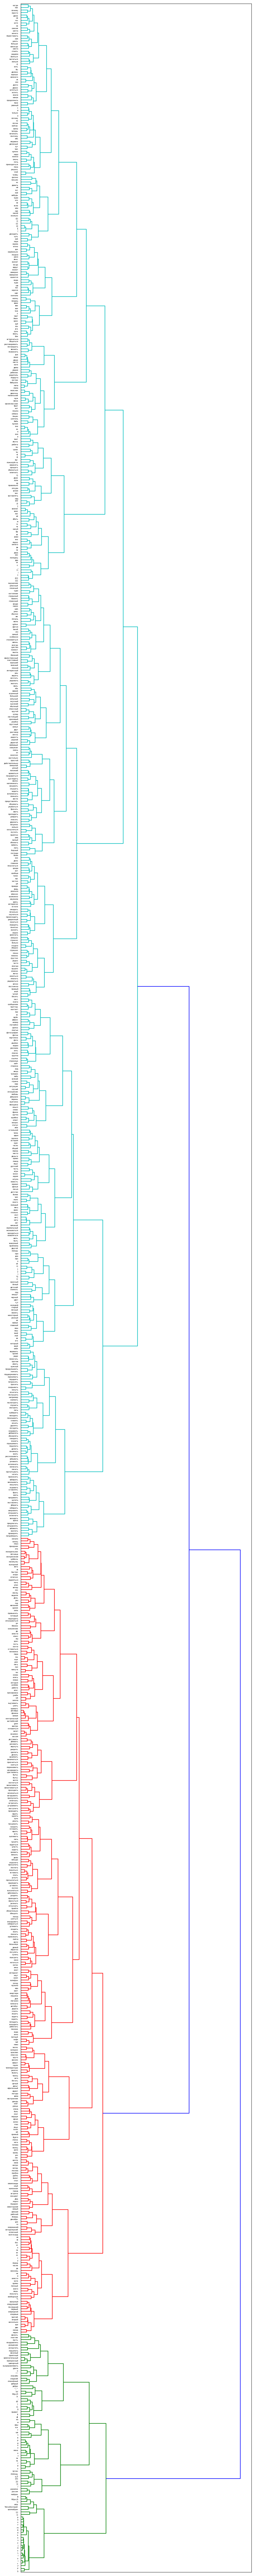

In [16]:
from scipy.cluster.hierarchy import  ward, dendrogram

linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 100)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=top_words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() 

plt.savefig('w2v_clusters.png', dpi=200) #save figure as ward_clusters

## Классификация текстов 

По мотивам http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [68]:
X = df.text.tolist()
y = df.sent.tolist()

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 151978
total test examples 74856


In [91]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [92]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [93]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])
rfc_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

In [95]:
rfc_w2v.fit(X_train,y_train)
pred = rfc_w2v.predict(X_test)

Precision:   0.79
Recall:   0.79
F1-measure:   0.79
Accuracy:   0.79
             precision    recall  f1-score   support

        neg       0.77      0.81      0.79     36971
        pos       0.81      0.76      0.78     37885

avg / total       0.79      0.79      0.79     74856



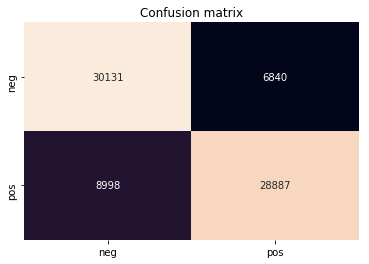

In [72]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [78]:
rfc_w2v_tfidf.fit(X_train,y_train)
pred = rfc_w2v_tfidf.predict(X_test)

Precision:   0.83
Recall:   0.83
F1-measure:   0.83
Accuracy:   0.83
             precision    recall  f1-score   support

        neg       0.82      0.86      0.84     36971
        pos       0.85      0.81      0.83     37885

avg / total       0.83      0.83      0.83     74856



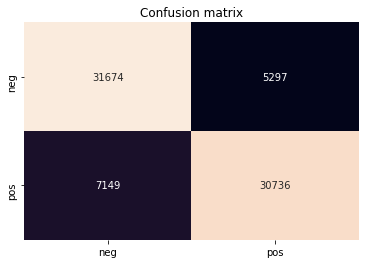

In [79]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## paragraph2vec aka doc2vec


word2vec с дополнительной меткой id документа

![img](img/w2v_4.png)

In [108]:
from gensim.models.doc2vec import *

In [124]:
splitted_texts = [text.split() for text in X]
idx = [str(i) for i in range(len(X))]

docs = []
for i in range(len(X)):
    docs.append(TaggedDocument(splitted_texts[i], [idx[i]]))


model = Doc2Vec(size=300, window=5, min_count=5, workers=8, alpha=0.025, min_alpha=0.01, dm=0)
model.build_vocab(docs)

# docvec1 = model.docvecs[0]
# docvecsyn1 = model.docvecs.doctag_syn0[0]
# docsim1 = model.docvecs.most_similar(id1)

model.train(docs, total_examples=len(docs), epochs=20)

44780904

In [148]:
class Doc2VecVectorizer(object):
    def __init__(self, d2v_model):
        self.d2v_model = d2v_model


    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.d2v_model.infer_vector(text.split()) for text in X])


rfc_d2v = Pipeline([
    ("word2vec vectorizer", Doc2VecVectorizer(model)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

rfc_d2v.fit(X_train,y_train)
pred = rfc_d2v.predict(X_test)

Precision:   0.63
Recall:   0.63
F1-measure:   0.63
Accuracy:   0.63
             precision    recall  f1-score   support

        neg       0.62      0.68      0.65     36971
        pos       0.65      0.59      0.62     37885

avg / total       0.63      0.63      0.63     74856



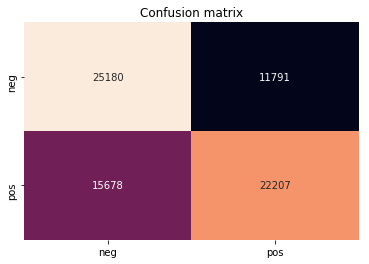

In [149]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## fasttext 

Слово $w$ представляем символьными $n$-грамами: 

$n=3$, $G_{where} = \_wh, whe, her, re\_, \_where\_$

$sim_{w2v}(u,v) = <u,v>$


$sim_{ft}(u,v) = \sum_{e \in G_u} \sum_{g \in G_v} <e,v>$


https://github.com/facebookresearch/fasttext

In [159]:
import fasttext

with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')
    

with open('test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + y_test[i] + ' ' + X_test[i] + '\n')

In [160]:
classifier = fasttext.supervised('data.train.txt', 'model')
result = classifier.test('test.txt')
print('P@1:', result.precision)
print('R@1:', result.recall)
print('Number of examples:', result.nexamples)

P@1: 0.9172411029176017
R@1: 0.9172411029176017
Number of examples: 74856


Precision:   0.92
Recall:   0.92
F1-measure:   0.92
Accuracy:   0.92
             precision    recall  f1-score   support

        neg       0.91      0.92      0.92     36971
        pos       0.92      0.91      0.92     37885

avg / total       0.92      0.92      0.92     74856



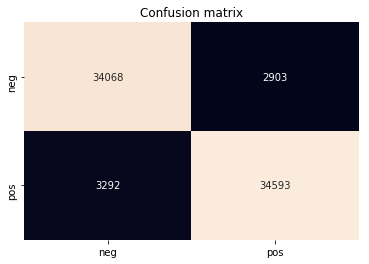

In [166]:
pred = classifier.predict(X_test)


print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, [i[0] for i in pred]))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()